
# **Agentic AI Chatbot Prototype 1**


# Installation

In [18]:
%%capture --no-stderr
%pip install --quiet -U langsmith langgraph langgraph-cli langchain_google_genai langgraph-checkpoint-postgres psycopg psycopg-pool psycopg-binary tavily-python langchain_community langchain-core==0.3.21

# Imports

In [20]:
import os
from google.colab import userdata
from IPython.display import Image, display
from typing import Literal, Dict, Union
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState

# Environment Variables

In [44]:
NEON_DB_URI = userdata.get("NEON_DB_URI")

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/dark-blade-437407-p5-1dfe0ef5e168.json'

os.environ["GEMINI_API_KEY"] = userdata.get("GEMINI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "healthcare-chatbot"

# Postgres DB

In [22]:
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}
pool = ConnectionPool(conninfo=NEON_DB_URI, max_size=30, kwargs=connection_kwargs)
checkpointer = PostgresSaver(pool)
checkpointer.setup()

# Graph State

In [23]:
class State(MessagesState):
    summary: str

# Tavily Search Tool

In [34]:
search_tool = TavilySearchResults(max_results=3)
tools = [search_tool]
tool_node = ToolNode(tools=tools)

# Generative Model

In [25]:
model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.2)
system_message = SystemMessage(content=(
    "You are an AI healthcare assistant. Your role is to provide information, "
    "advice, and guidance related to healthcare topics such as symptoms, medications, "
    "mental well-being, and healthcare services. Always ensure responses are accurate, "
    "empathetic, and within your scope as a digital assistant."
))
model = model.bind_tools(tools)

# Summarize Conversation

In [36]:
def summarize_conversation(state: State) -> State:
    """
    Summarizes healthcare-related conversations if there are more than 6 messages.
    """
    summary = state.get("summary", "")
    summary_prompt = (
        f"Existing summary: {summary}\n\nSummarize new healthcare-related messages:"
        if summary
        else "Summarize the healthcare conversation above:"
    )

    messages = state["messages"] + [HumanMessage(content=summary_prompt)]
    response = model.invoke(messages)

    state["summary"] = response.content
    state["messages"] = state["messages"][-2:]  # Retain last 2 messages only

# Condtional Function

In [27]:
def select_next_node(state: State) -> Union[Literal["tools", "summarize_conversation"], str]:
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    if messages[-1].tool_calls:
        return "tools"
    return END

# Agent

In [28]:
def call_model(state: State) -> Dict[str, object]:
    messages = state.get("messages", [])
    summary = state.get("summary", "")

    # Prepend the system message and existing summary if available
    messages = [system_message] + ([SystemMessage(content=f"Summary so far: {summary}")] if summary else []) + messages

    try:
        response = model.invoke(messages)
        messages.append(response)
    except Exception as e:
        raise RuntimeError(f"Model invocation failed: {e}")

    return {"messages": messages[-1]}

# Graph

In [45]:
builder = StateGraph(State)
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
builder.add_node("summarize_conversation", summarize_conversation)
builder.add_edge(START, "agent")
builder.add_edge("tools", "agent")
builder.add_edge("summarize_conversation", END)

builder.add_conditional_edges(
    "agent",
    select_next_node,
    {"summarize_conversation": "summarize_conversation", "tools": "tools", END: END},
)

graph = builder.compile()

# Display Graph

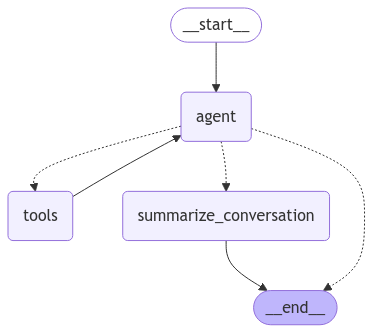

In [46]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Start Conversation


In [ ]:
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x79ef67a735b0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go